In [1]:
#Import numerical stuff
import numpy as np
import torch
#System
import re
import os
import sys
from typing import List
from pathlib import Path
from functools import partial
#CV
import matplotlib.pyplot as plt
import nibabel as nib
import cv2
from skimage.transform import resize
from sklearn.model_selection import train_test_split
#Additional things
%matplotlib inline
if(re.search(".*\/([^\/]+)\/", os.getcwd()).group()[-12:] == "unet-csc509/"):
    #os.chdir("../../")
    #print("changed dir to /src")
    #print(os.getcwd())
    sys.path.append("../")
import models.image_utils as img_utils

In [2]:
data = np.load("../images/Module1_BraTS/MRI_train_images.npy")

### Playing with the images
- we can test out filters by applying a mask
- then, we can modify our Y values (desired output of dataset) to classify what we want

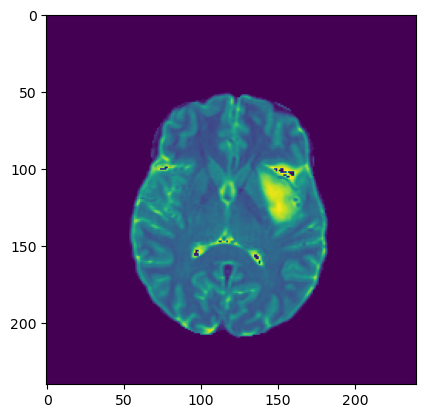

In [3]:
#Original image
img = data[28, :, :, 0]
plt.imshow(img)

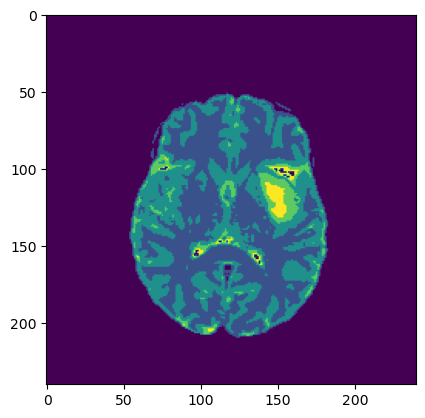

In [4]:
img = data[28, :, :, 0] * 4.
img = np.rint(img)
#1,2,3,4 image
plt.imshow(img)
#np.ptp(img,axis=1)

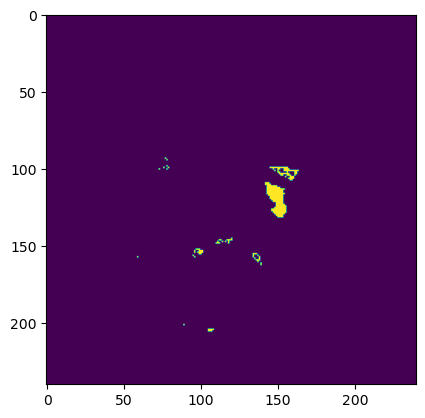

In [5]:
#image with just 4 highlighted
img[img != 4.] = 0
plt.imshow(img)

## Turning Data Transformation into a Module

### NIFTI transforms (individual)

In [6]:
import torch
torch.cuda.is_available()

True

In [7]:
# test_data = np.load("../images/Module1_BraTS/MRI_test_label.npy")
# test_data = test_data[0, :, :, 0]
# plt.imshow(test_data)

In [8]:
import nibabel as nib

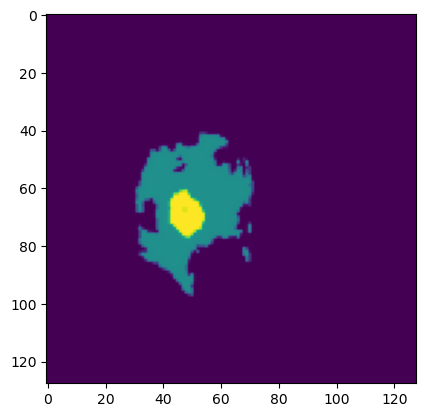

In [9]:
img_path = "../images/Module1_BraTS/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii.gz"
init_nifti = img_utils.get_nifti(img_path)
#sample_nifti = img_utils.filter_nifti(init_nifti, [4.])
plt.imshow(init_nifti)

### Figuring out PATH for Batch NIFTI loading

In [10]:

TRAIN_DATA_PATH = Path('../images/Module1_BraTS/MICCAI_BraTS2020_TrainingData')
train_dir = [f.path for f in os.scandir(TRAIN_DATA_PATH) if f.is_dir()]
def list_to_ids(dir:str):
    """
    Will convert the dir paths to ids by parsing the paths.
    dir: string, image dir paths in BRATS
    """
    x = []
    for i in range(0,len(dir)):
        x.append(dir[i].split('/')[-1])
    return x

ids = list_to_ids(train_dir)
train_ids, test_ids = train_test_split(ids,test_size=0.2)
train_ids, val_ids = train_test_split(train_ids,test_size=0.2)

# Now looks at the number of patient ids in training, validation and test sets
print(f'There are {len(train_ids)} patient ids in training set')
print(f'There are {len(val_ids)} patient ids in validation set')
print(f'There are {len(test_ids)} patient ids in test set')


There are 236 patient ids in training set
There are 59 patient ids in validation set
There are 74 patient ids in test set


#### Comment: And we see that we get proper tensor shape for U-Net Multi-modal

In [11]:
#Sample individual NIFTI
#get_nifti(train_ids[1], TRAIN_DATA_PATH, ['t2', 'seg']).shape

#Get tensors of full NIFTI
train_tensor = img_utils.get_tensors(train_ids, TRAIN_DATA_PATH, ['t2', 'seg'])
train_tensor.shape

  1%|▋                                                                                  | 2/235 [00:00<00:18, 12.72it/s]/home/kkang2097/github/unet-csc509/notebooks/../models/image_utils.py:20: RuntimeWarning: invalid value encountered in divide
  return (sample_nifti - min)/(max - min)
100%|█████████████████████████████████████████████████████████████████████████████████| 235/235 [00:14<00:00, 15.99it/s]


(235, 128, 128, 2)

#### Let's see if we can mass-filter the masks
- we know the whole tumor is on the 4th axis, last index of the data tensors

In [12]:
filtered_train_tensor = img_utils.bulk_mask_filter(train_tensor, [1., 2., 4.])

In [13]:
filtered_train_tensor.shape

(235, 128, 128, 2)

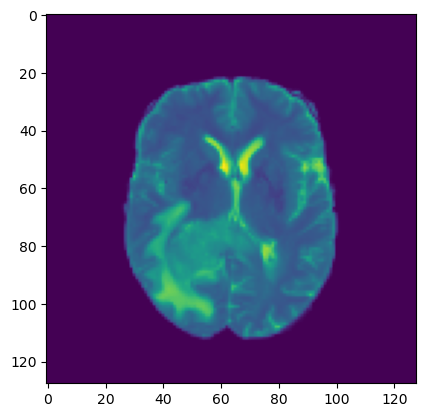

In [14]:
#Whole image
plt.imshow(filtered_train_tensor[2, :, :, 0])

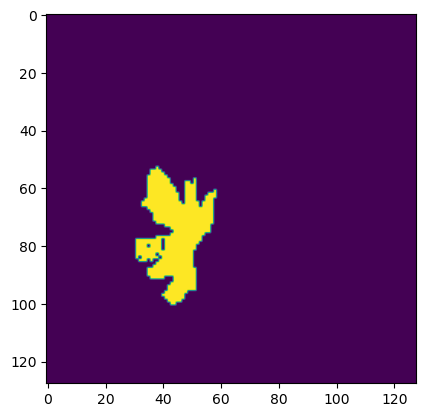

In [19]:
#Tumor visualization
plt.imshow(filtered_train_tensor[1, :, :, 1])

#### Shuffle the dataset! Don't forget this

In [23]:
#The dataset is shuffled along the first axis, which is sample number
shuffled_array = np.random.shuffle(filtered_train_tensor)
#The results of our shuffle don't ruin our dataset!

#Proof:
#plt.imshow(filtered_train_tensor[2, :, :, 1])